In [157]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [158]:
# Load dataset
df = pd.read_csv('./dataset/attendance.csv')

In [159]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
df['y'] = labelencoder.fit_transform(df['result'])

In [160]:
X = df['command'].values
y = df['y'].values

In [161]:
# Create features
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    sublinear_tf=True, 
    min_df=3, norm='l2', 
    encoding='latin-1', 
    ngram_range=(1, 2))

In [162]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [163]:
# Model
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
#model = LinearSVC()
model = XGBClassifier(objective="multiclass", eval_metric="mlogloss", random_state=42, use_label_encoder=False)


In [164]:
from sklearn.pipeline import Pipeline

In [165]:
pipeline = Pipeline([('tfidf', tfidf), ('classifier', model)])

In [166]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(encoding='latin-1', min_df=3,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='mlogloss', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, reg_lam

In [167]:
pipeline.score(X_test, y_test)

0.7435897435897436

In [168]:
pipeline.predict_proba(["time in po muna"])

array([[2.118425e-03, 7.985685e-04, 9.895154e-01, 7.567598e-03]],
      dtype=float32)

In [169]:
labelencoder.classes_

array(['BREAK', 'RESUME', 'TIMEIN', 'TIMEOUT'], dtype=object)

In [170]:
def classify(command):
    classes = labelencoder.classes_
    prediction = pipeline.predict_proba([command])[0]
    predicted_class = np.where(prediction == np.amax(prediction))
    idx = predicted_class[0][0]
    return classes[idx], prediction[idx]


In [171]:
classify("time out po muna")
#classify("break po muna ako. balik ako later")
#classify("papasok po si cassy")
#classify("time out po muna ako ngayon")

('TIMEOUT', 0.98992693)

# Save Model

In [172]:
# Save Model using pickle
import pickle
filename = 'model.pickle'
classifier = {
    "model": pipeline,
    "classes": labelencoder.classes_
}
pickle.dump(classifier, open(filename, 'wb'))

In [173]:
# Load Model using pickle
loaded_classifier = pickle.load(open(filename, 'rb'))
loaded_classifier["model"].score(X_test, y_test)

0.7435897435897436

In [174]:
# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_hat = pipeline.predict(X_test)

def plot_confusion_matrix(model):
    cm = confusion_matrix(y_test, y_hat, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelencoder.classes_)
    disp.plot()
    plt.show()

In [175]:
# display failed predictions
for text, prediction, truth in zip(X_test, y_hat, y_test):
    if(prediction == truth):
        continue
    print(text, labelencoder.classes_[prediction], labelencoder.classes_[truth])

tumein TIMEOUT TIMEIN
bresk po TIMEOUT BREAK
timd oht po ulit RESUME TIMEOUT
tilein uoit TIMEOUT TIMEIN
tilein juna TIMEOUT TIMEIN
breaj po uoit TIMEOUT BREAK
brsak uoit TIMEOUT BREAK
time outgulit TIMEIN TIMEOUT
brral po luna ulit TIMEIN BREAK
gimein po TIMEOUT TIMEIN


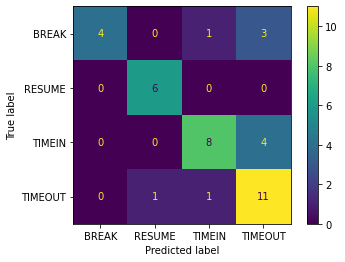

In [176]:
plot_confusion_matrix(pipeline)

In [179]:
classify("tilein uoit")

('TIMEOUT', 0.33101025)

In [180]:
classify("time out po muna ako hehe")

('TIMEOUT', 0.98992693)